
# Формулировка задачи:
---

Требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.

Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок.  В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.

Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.

Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. Изначально колонка заполнена значением 0.

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split
from collections import defaultdict

rand_state = 666

In [74]:
train_data = pd.read_csv('dataset/train.tsv', sep = '\t')
#print(train_data['is_fake'].value_counts())
#train_data.style.hide_index()
train_data

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
...,...,...
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,Правительство застроит Россию нефтепродуктопро...,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,Туркмения в декабре начнет поставки газа в Китай,0


---
# 1. Предобработка заголовков:


1) Приведём заголовки к нижнему регистру

2) Удалим все лишние символы

3) Уберём все стоп-слова (что, чтобы, как итд..)

4) Приведём каждое оставшееся слово к лемме (языковой единице в инфинитиве)

5) Применим подход TF-IDF


In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
def preprocessing(df):
    
    '''df = any given DataFrame with title names'''
    
    len_df = len(df)
    stop_words = set(stopwords.words('russian'))
    morph = MorphAnalyzer()
    
    for i in range(len_df):

        # приведение к нижнему регистру:
        title = df['title'][i].lower()
        
        # удаление лишних символов:
        title = re.sub('<.*?>', ' ', title)
        title = re.sub(' +', ' ', title)
        title = re.sub(r'[^\w\s]', '', title)
        title = re.sub('\n', '', title)
        
        # токенизация:
        title_words = word_tokenize(title)
        preprocessed_title = []

        # удаление стоп слов + лемматизация:
        for word in title_words:
            if word not in stop_words:
                p = morph.parse(word)[0]
                preprocessed_title.append(p.normal_form)

        df['title'][i] = " ".join(preprocessed_title)
        
    # В ходе исслаодвания также пробовал стеммер nltk.stem.snowball.SnowballStemmer, 
    # Он давал схожую точность, но не всегда верно обрабатывал слова (Навальный -> Навальн итд)
    
    return df

train_data = preprocessing(train_data)
train_data

,title,is_fake
0,москвич владимир клутина прийти счёт вмешатель...,1
1,агент кокорин назвать езда встречка житейский ...,0
2,госдума рассмотреть возможность введение секре...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный завести дело недоносительство...,1
...,...,...
5753,эдди чемберс получить сотрясение мозг бой кличко,0
5754,правительство застроить россия нефтепродуктопр...,0
5755,стыдно дед новый канцлер фрг обратиться первый...,1
5756,туркмения декабрь начать поставка газ китай,0


In [77]:
# применяем подход TF-IDF (term frequency * inverse data frequency):

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(train_data['title'])
y_train = train_data['is_fake']

tmp = train_x_vect.toarray().shape
print('по всем {0} сообщениям набралось {1} уникальных слов'.format(tmp[0], tmp[1]))

по всем 5758 сообщениям набралось 11119 уникальных слов


---
# 2. Модель SVC (Support Vector Classifier):

In [6]:
# Метод опорных векоторов с линейным ядром - выберем оптимальный параметр штрафа перебором:
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_state)
clf = SVC(kernel = 'linear', random_state = rand_state)

grid_svc_lin = {'C': np.linspace(0.5, 1.5, 11)}
gs_svc_lin = GridSearchCV(clf, grid_svc_lin, scoring = 'f1', cv = cv)
gs_svc_lin.fit(train_x_vect, y_train)

print('Max f1 score: {}'.format(gs_svc_lin.best_score_))
print('Parameter for this score: {}'.format(gs_svc_lin.best_params_))

Max f1 score: 0.842385576527881
Parameter for this score: {'C': 0.7}


In [7]:
# Луший линейный классификатор:
svc_clf_lin = SVC(kernel = 'linear', C = gs_svc_lin.best_params_['C'], random_state = rand_state)
svc_clf_lin.fit(train_x_vect, y_train)

# Топ 20 самых значимых слов:
A = svc_clf_lin.coef_.indices
B = np.abs(svc_clf_lin.coef_.data)
most_important_words = A[B.argsort()[-20:][::-1]]

print('Top 20 most important words for this model: \n')
for i in most_important_words:
    print('{}'.format(vectorizer.get_feature_names()[i]))

Top 20 most important words for this model: 

навальный
запретить
гражданин
байден
который
россиянин
роскосмос
рпц
лукашенко
млн
дмитрий
нефть
депутат
нобелевский
выборы
обязать
вакцина
коронавирус
сколково
банк


In [8]:
# Попробуем метод с полиномиальным ядром.
# Также будем выбирать оптимальные параиметры перебором:

svc_grid_poly = {'degree': np.arange(1, 5), 'C': np.logspace(-1, 1, 10)}
clf = SVC(kernel = 'poly', random_state = rand_state)

gs_svc_poly = GridSearchCV(clf, svc_grid_poly, scoring = 'f1', cv = cv)
gs_svc_poly.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_svc_poly.best_score_))
print('parameters for this score: {}\n'.format(gs_svc_poly.best_params_))

max f1 score: 0.849111705199333
parameters for this score: {'C': 0.774263682681127, 'degree': 2}



In [9]:
# Полиномиальная модель даёт лучшие результаты по метрике f1.
# Строим новую модель на лучших парметрах:
svc_clf = SVC(kernel = 'poly', 
              C = gs_svc_poly.best_params_['C'],
              degree = gs_svc_poly.best_params_['degree'],
              random_state = rand_state)
svc_clf.fit(train_x_vect, y_train)

# Ответ на тестовых данных:
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
test_data = preprocessing(test_data)
test_data['is_fake'] = svc_clf.predict(vectorizer.transform(test_data['title']))

#test_data.style.hide_index()
test_data.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор ( ...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь , собрать рекордно низкий кол...",1
4,акция google рухнуть объявление перезапуск rutube,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,1
9,учредить театральный премия имя гарольд пинтер,0




---

# 3. Модель RF (Random Forest):

In [10]:
# Подбираем лучшие параметры:
grid_rfc = {'n_estimators': np.arange(150, 200, 5), 'max_depth': np.arange(10, 25)}
clf = RFC(random_state = rand_state)

gs_rfc = GridSearchCV(clf, grid_rfc, scoring = 'f1', cv = cv)
gs_rfc.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_rfc.best_score_))
print('params for this score: {}'.format(gs_rfc.best_params_))

max f1 score: 0.7560622538764503
params for this score: {'max_depth': 21, 'n_estimators': 185}


---
# 4. Модель kNN (k Nearest Neighbours):

In [11]:
# Подбираем лучшие параметры:
grid_knn = {'n_neighbors': np.arange(5, 25)}
clf = KNN()

gs_knn = GridSearchCV(clf, grid_knn, scoring = 'f1', cv = cv)
gs_knn.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_knn.best_score_))
print('params for this score: {}\n'.format(gs_knn.best_params_))

max f1 score: 0.7989517994396899
params for this score: {'n_neighbors': 9}



---
# 5. Модель MNB (Multinomial Naive Bayes):

In [12]:
# Подбираем лучшие параметры:
grid_mnb = {'alpha': np.linspace(0.5, 1.5, 21)}
clf = MNB()

gs_mnb = GridSearchCV(clf, grid_mnb, scoring = 'f1', cv = cv)
gs_mnb.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_mnb.best_score_))
print('params for this score: {}\n'.format(gs_mnb.best_params_))

max f1 score: 0.8531413845419911
params for this score: {'alpha': 1.3}



---
# 6. Модель LR (Logistic Regression):

In [13]:
# Подбираем лучшие параметры:
lr_grid = {'C': np.linspace(8, 10, 10)}
clf = LogisticRegression(random_state = rand_state)

gs_lr = GridSearchCV(clf, lr_grid, scoring = 'f1', cv = cv)
gs_lr.fit(train_x_vect, y_train)

print('max f1 score: {}'.format(gs_lr.best_score_))
print('parameters for this score: {}\n'.format(gs_lr.best_params_))

max f1 score: 0.8433327484332904
parameters for this score: {'C': 9.555555555555555}




---
# 7. Сравнение моделей:

In [62]:
# Разобьём тренировочный датасет на тренировочную/тестовую выборки 8/2:

train_data = pd.read_csv('dataset/train.tsv', sep = '\t')
train_data = preprocessing(train_data)
X_train, X_test, y_train, y_test = train_test_split(train_data['title'],
                                                    train_data['is_fake'],
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(X_train)
test_x_vect = vectorizer.transform(X_test)

In [63]:
# Строим новые классификаторы на лучших параметрах
model_names_arr = ['SVC_linear', 'SVC_poly2', 'RF', 'kNN', 'MNB', 'LR']
prob_pred_dict = {}

for num, name in enumerate(model_names_arr):
    
    if num == 0:
        clf = SVC(probability = True,
                  kernel = 'linear',
                  C = gs_svc_lin.best_params_['C'],
                  random_state = rand_state)
    elif num == 1:
        clf = SVC(probability = True,
                  kernel = 'poly',
                  C = gs_svc_poly.best_params_['C'],
                  degree = gs_svc_poly.best_params_['degree'],
                  random_state = rand_state)
    elif num == 2:
        clf = RFC(n_estimators = gs_rfc.best_params_['n_estimators'],
                  max_depth = gs_rfc.best_params_['max_depth'],
                  random_state = rand_state)
    elif num == 3:
        clf = KNN(n_neighbors = gs_knn.best_params_['n_neighbors'])
    elif num == 4:
        clf = MNB(alpha = gs_mnb.best_params_['alpha'])
    elif num == 5:
        clf = LogisticRegression(C = gs_lr.best_params_['C'],
                                 random_state = rand_state)

    
    clf.fit(train_x_vect, y_train)
    prob_pred_dict[name] = clf.predict_proba(test_x_vect)[:, 1]


# Датафрейм с вероятностями события is_fake == 1
prob_pred_dict['title'] = X_test
prob_pred_dict['is_fake'] = y_test
prob_pred_df = pd.DataFrame(prob_pred_dict)
prob_pred_df

,SVC_linear,SVC_poly2,RF,kNN,MNB,LR,title,is_fake
3986,0.221720,0.140556,0.452154,0.222222,0.395533,0.242337,финский хоккеистка выиграть бронза игр2010,0
1430,0.112592,0.129996,0.494052,0.222222,0.349372,0.165201,ген определить шанс выжить заражение вирус эбола,0
5304,0.873424,0.777668,0.500659,0.777778,0.666074,0.800565,эрдоган израиль заплатить агрессия против раке...,1
4907,0.679209,0.471134,0.531654,0.333333,0.496288,0.552571,сергей макаров ввести зал слава нхл,0
5494,0.835226,0.901700,0.503263,0.777778,0.725222,0.823613,должный повториться глава якутия поручить выру...,1
...,...,...,...,...,...,...,...,...
5153,0.349470,0.573912,0.510333,0.555556,0.531037,0.398055,росавиация отказаться прекращать полёт крым из...,0
2206,0.965063,0.961210,0.565327,0.777778,0.719189,0.897692,журналист nexta обнаружить лукашенко тайный ск...,1
1563,0.194527,0.336616,0.494052,0.444444,0.424061,0.253370,евровидение передумать устраивать иерусалим ск...,0
2641,0.153859,0.145161,0.486890,0.333333,0.411533,0.254870,oshkosh получить заказ тысяча бронетранспортёр,0


<AxesSubplot:>

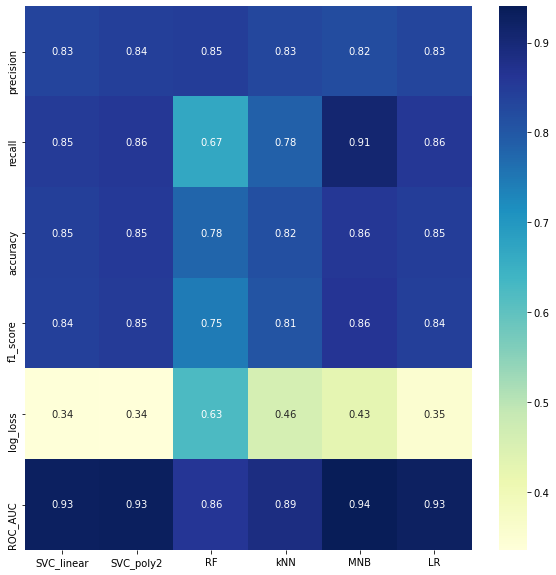

In [64]:
# HeatMap plot with metrics:

metrics_dict = defaultdict(dict)
threshold = 0.5

for name in model_names_arr:
    
    # Forming predicted class:
    predicted_class = (prob_pred_df[name] > threshold).astype(int)
    
    # Computing all metrics:
    precision, recall, f_score, _ = metrics.precision_recall_fscore_support(prob_pred_df['is_fake'],\
                                                                            predicted_class, average = 'binary')
    
    accuracy = metrics.accuracy_score(prob_pred_df['is_fake'], predicted_class)
    log_loss = metrics.log_loss(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])

    metric_name_value_pairs = zip(('precision', 'recall', 'accuracy', 'f1_score', 'log_loss', 'ROC_AUC'),\
                                  (precision, recall, accuracy, f_score, log_loss, roc_auc))
    
    # Building metrics dict:
    for metric_name, metric_value in metric_name_value_pairs:
        metrics_dict[name][metric_name] = metric_value

df_metrics = pd.DataFrame(metrics_dict)
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df_metrics, annot = True, cmap = 'YlGnBu')

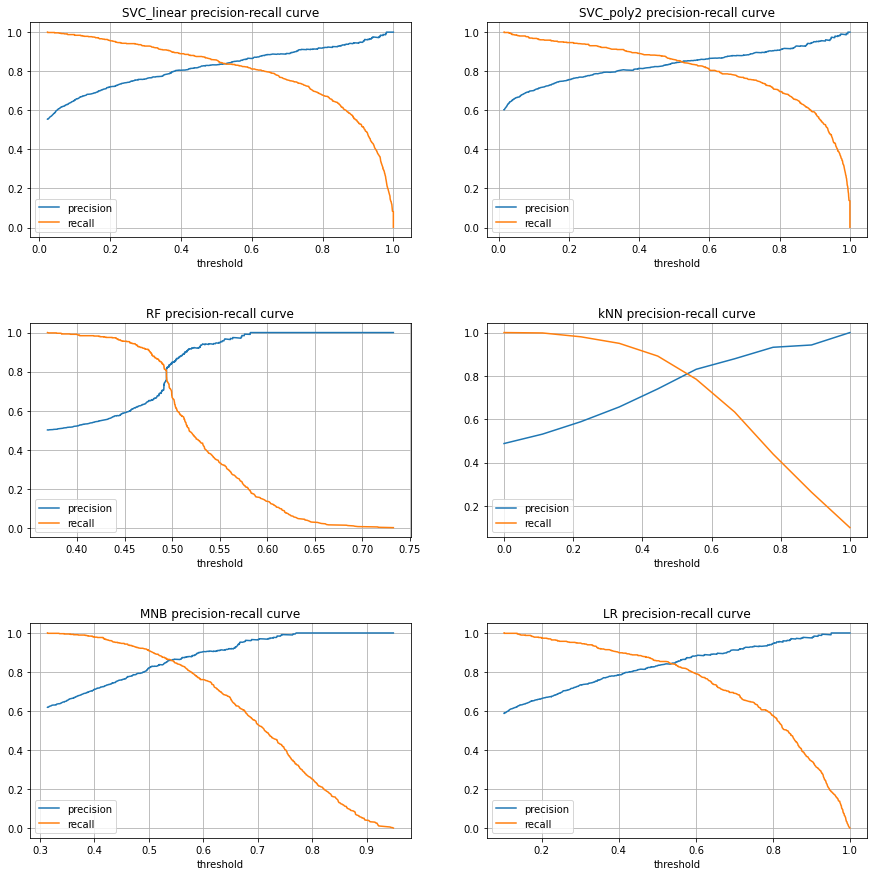

In [65]:
# Precision-recall curves:

fig = plt.subplots(figsize = (15, 15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

for i, name in enumerate(model_names_arr):
    
    precision, recall, threshold = metrics.precision_recall_curve(prob_pred_df['is_fake'],  prob_pred_df[name])
    plt.subplot(3, 2, i + 1)
    plt.plot(threshold, precision[:-1], label = 'precision')
    plt.plot(threshold, recall[:-1], label = 'recall')
    
    plt.xlabel('threshold')
    plt.title(f'{name} precision-recall curve')
    plt.legend()
    plt.grid()

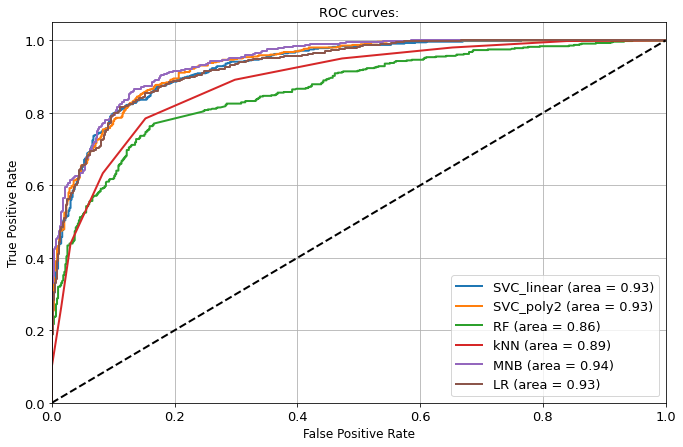

In [66]:
# Roc-curves:

fig = plt.subplots(figsize = (11, 7))

for name in model_names_arr:
    
    fpr, tpr, _ = metrics.roc_curve(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])
    plt.plot(fpr, tpr, lw = 2, label = f"{name} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)

plt.title('ROC curves:', fontsize = 13)
plt.legend(loc = 'best', fontsize = 13)
plt.grid()
plt.show()

---
# 8* подход Word2Vec:

Попробуем векторное представление слов вместо TF_IDF. Алгоритм здесь будет следующий:

1) Составление словаря слов и его последующая их векторизация (реализованы в модуле gensim):

- Обозначим размерность полученного векторного простравства за $dim$, преобразование будет выглядеть как ${word}_{i} \rightarrow [w_{i, 1}, w_{i, 2}, .., w_{i, dim}]$, где $w_{i, j}$ - j-я координата i-го слова.

2) Составление признаков по следующему правилу (правило стоит модернизировать): 

- Обозначим количество слов в i-м заголовке за $N_{i}$. Тогда для каждого i-го заголовка получим $dim$ признаков, суммируя координаты каждого из $N_{i}$ слов: $F_{i} = [ F_{i, 1}, F_{i, 2}, .., F_{i, dim} ]= [\sum_{j = 1}^{N_i} w_{1, j}, \sum_{j = 1}^{N_i} w_{2, j}, .., \sum_{j = 1}^{N_i} w_{dim, j}]$

3) Обучение модели на полученных признаках

In [142]:
import gensim
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('dataset/train.tsv', sep = '\t')#.apply(lambda x: x.astype(str).str.lower())
#df = preprocessing(df)

tokens = [word_tokenize(title) for title in df['title']]

# векторизация:
dim_size = 10
model = gensim.models.Word2Vec(tokens, min_count = 1, size = dim_size)

In [143]:
# Составление признаков:
for col_num in range(dim_size):
    df[col_num] = .0

for title_num, title in enumerate(tokens):
    
    res_vec = np.array([.0] * dim_size)
    for word in title:
        res_vec += np.array(model[word])
    
    for col_num in range(dim_size):
        df[col_num][title_num] = res_vec[col_num]

In [144]:
# Строим классификаторы:
model_names_arr = ['SVC_linear', 'SVC_poly2', 'RF', 'kNN', 'GNB', 'LR']
prob_pred_dict = {}

# разделение на train/test в соотнощении 8/2
threshold = int(0.8 * len(df))
train_df, test_df = df[:threshold], df[threshold:]
x_train, y_train = train_df[df.columns[2:]], train_df['is_fake']#.astype('int')
x_test, y_test = test_df[df.columns[2:]], test_df['is_fake']#.astype('int')

for num, name in enumerate(model_names_arr):
    
    if num == 0:
        clf = SVC(probability = True,
                  kernel = 'linear',
                  random_state = rand_state)
    elif num == 1:
        clf = SVC(probability = True,
                  kernel = 'poly',
                  degree = 2,
                  random_state = rand_state)
    elif num == 2:
        clf = RFC(max_depth = 20,
                  random_state = rand_state)
    elif num == 3:
        clf = KNN(n_neighbors = 10)
    elif num ==4:
        clf = GaussianNB()
    elif num == 5:
        clf = LogisticRegression(random_state = rand_state)

    
    clf.fit(x_train, y_train)
    prob_pred_dict[name] = clf.predict_proba(x_test)[:, 1]


# Датафрейм с вероятностями события is_fake == 1
prob_pred_dict['title'] = pd.read_csv('dataset/train.tsv', sep = '\t')['title'][threshold:]
prob_pred_dict['is_fake'] = y_test
prob_pred_df = pd.DataFrame(prob_pred_dict)
prob_pred_df

,SVC_linear,SVC_poly2,RF,kNN,GNB,LR,title,is_fake
4606,0.223409,0.327600,0.242245,0.4,0.000757,0.217788,На базе Чернобыльской АЭС создадут центр ГМО,1
4607,0.388353,0.383728,0.471464,0.3,0.010102,0.374228,IKEA построит офисный центр в Подмосковье,0
4608,0.510006,0.435367,0.354155,0.4,0.007484,0.505621,Герман Греф предложил выдавать кредиты с 14 лет,1
4609,0.450828,0.415451,0.498854,0.5,0.028209,0.444435,Российские ученые нашли «спусковой крючок» бол...,0
4610,0.235940,0.334332,0.147419,0.2,0.000561,0.241453,Инспекторы ГИБДД смогут вакцинировать граждан,1
...,...,...,...,...,...,...,...,...
5753,0.583029,0.540762,0.333049,0.3,0.701557,0.584221,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,0.230845,0.333984,0.246771,0.4,0.000644,0.229830,Правительство застроит Россию нефтепродуктопро...,0
5755,0.740354,0.793056,0.660000,0.9,1.000000,0.745456,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,0.694116,0.665192,0.488749,0.5,0.998130,0.690511,Туркмения в декабре начнет поставки газа в Китай,0


<AxesSubplot:>

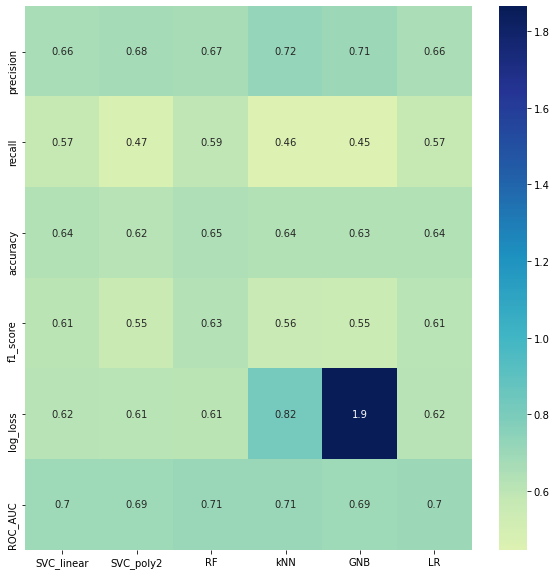

In [145]:
# HeatMap plot with metrics:

metrics_dict = defaultdict(dict)
threshold = 0.5

for name in model_names_arr:
    
    # Forming predicted class:
    predicted_class = (prob_pred_df[name] > threshold).astype(int)
    
    # Computing all metrics:
    precision, recall, f_score, _ = metrics.precision_recall_fscore_support(prob_pred_df['is_fake'],\
                                                                            predicted_class, average = 'binary')
    
    accuracy = metrics.accuracy_score(prob_pred_df['is_fake'], predicted_class)
    log_loss = metrics.log_loss(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])

    metric_name_value_pairs = zip(('precision', 'recall', 'accuracy', 'f1_score', 'log_loss', 'ROC_AUC'),\
                                  (precision, recall, accuracy, f_score, log_loss, roc_auc))
    
    # Building metrics dict:
    for metric_name, metric_value in metric_name_value_pairs:
        metrics_dict[name][metric_name] = metric_value

df_metrics = pd.DataFrame(metrics_dict)
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df_metrics, annot = True, cmap = 'YlGnBu', center = 1)

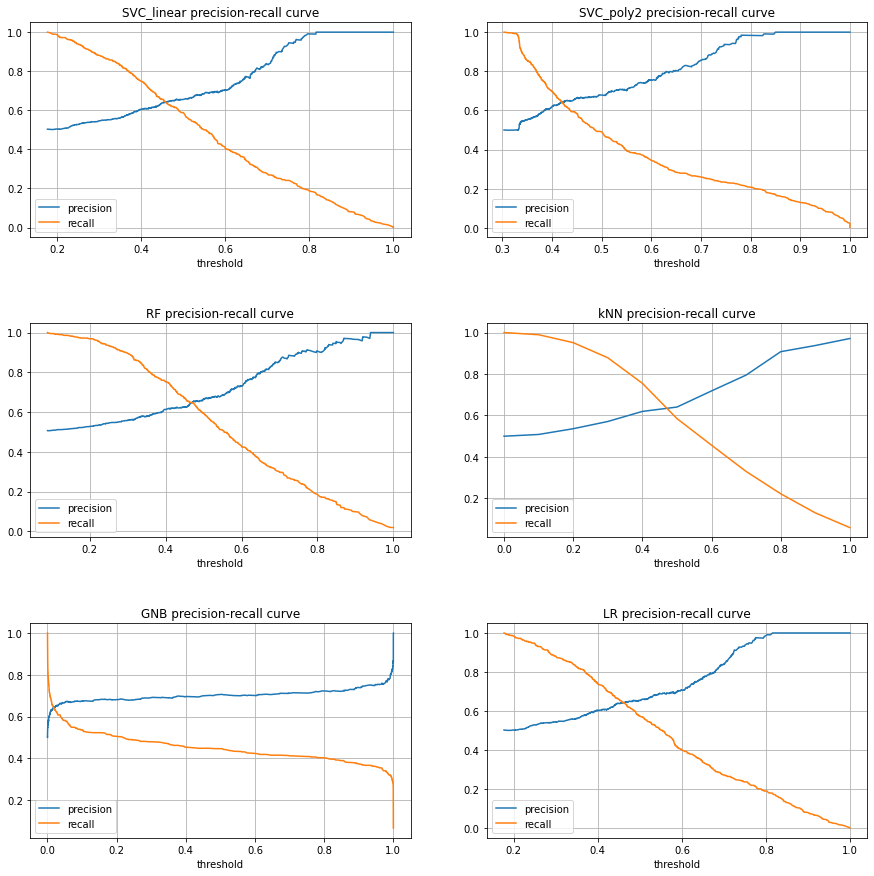

In [146]:
#Precision-recall curves:

fig = plt.subplots(figsize = (15, 15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)

for i, name in enumerate(model_names_arr):
    
    precision, recall, threshold = metrics.precision_recall_curve(prob_pred_df['is_fake'],  prob_pred_df[name])
    plt.subplot(3, 2, i + 1)
    plt.plot(threshold, precision[:-1], label = 'precision')
    plt.plot(threshold, recall[:-1], label = 'recall')
    
    plt.xlabel('threshold')
    plt.title(f'{name} precision-recall curve')
    plt.legend()
    plt.grid()

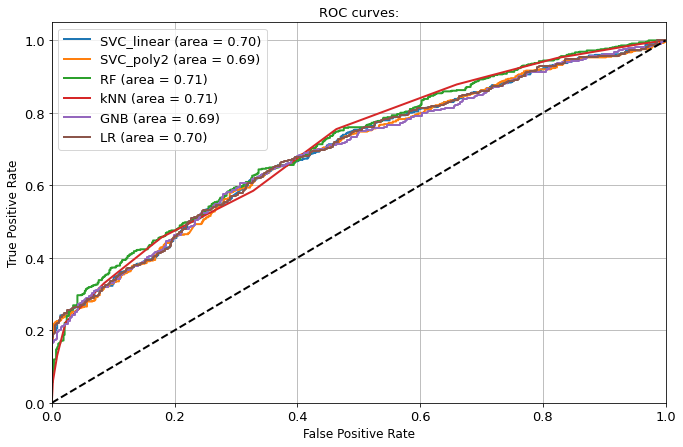

In [147]:
# Roc-curves:

fig = plt.subplots(figsize = (11, 7))

for name in model_names_arr:
    
    fpr, tpr, _ = metrics.roc_curve(prob_pred_df['is_fake'], prob_pred_df[name])
    roc_auc = metrics.roc_auc_score(prob_pred_df['is_fake'], prob_pred_df[name])
    plt.plot(fpr, tpr, lw = 2, label = f"{name} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)

plt.title('ROC curves:', fontsize = 13)
plt.legend(loc = 'best', fontsize = 13)
plt.grid()
plt.show()

---
# 9. Вывод:

 - Судя по HeatMap и AUC-ROC кривым из прошлых двух пунктов, наилучшим оказался подход TF-IDF + наивный байесовский классификатор.


 - Стоит отметить, что значение кросс-энтропии у классификаторов на сонвое метода опорных векторов и логистической регрессии оказалось ниже, чем у байесовского. Однако, поскольку ответ будет оцениваться по метрике F1- решил выбрать именно байесовский классификатор.

In [140]:
# Обучение наилучшего классификатора из исследованных и вывод результата
import os

train_data = preprocessing(pd.read_csv('dataset/train.tsv', sep = '\t'))
test_data = pd.read_csv('dataset/test.tsv', sep = '\t')
original_test_titles = test_data['title'].copy()
test_data = preprocessing(test_data)

vectorizer = TfidfVectorizer()
train_x_vect = vectorizer.fit_transform(train_data['title'])

best_clf = MNB(alpha = gs_mnb.best_params_['alpha'])
best_clf.fit(train_x_vect, train_data['is_fake'])

test_data['is_fake'] = best_clf.predict(vectorizer.transform(test_data['title']))
test_data['title'] = original_test_titles

test_data.to_csv('{}\\predictions.tsv'.format(os.path.normpath(os.getcwd() + os.sep + os.pardir)), 
                 index = False, 
                 sep = '\t')

In [141]:
# Сохранение итоговой модели на диск:
import pickle

filename = 'finalized_model.sav'
pickle.dump(best_clf, open(filename, 'wb'))